In [30]:
import numpy as np
import math as m
import rk4
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

In [31]:
eqs = np.array([
    lambda t, x, v: x[2],
    lambda t, x, v: x[3],
    lambda t, x, v: -v["mu"] * (x[0] / (x[0]**2 + x[1]**2)**1.5) + (v["f_eng"] * m.cos(v["u"])) / x[4],
    lambda t, x, v: -v["mu"] * (x[1] / (x[0]**2 + x[1]**2)**1.5) + (v["f_eng"] * m.sin(v["u"])) / x[4],
    lambda t, x, v: -v["gamma"],
    lambda t, x, v: (x[7] * v["mu"]) / (x[0]**2 + x[1]**2)**1.5 - (3 * v["mu"] * x[0] * (x[7] * x[0] + x[8] * x[1])) / (x[0]**2 + x[1]**2)**2.5,
    lambda t, x, v: (x[8] * v["mu"]) / (x[0]**2 + x[1]**2)**1.5 - (3 * v["mu"] * x[1] * (x[7] * x[0] + x[8] * x[1])) / (x[0]**2 + x[1]**2)**2.5,
    lambda t, x, v: -x[5],
    lambda t, x, v: -x[6],
    lambda t, x, v: v["f_eng"] * (x[7] * m.cos(v["u"]) + x[8] * m.sin(v["u"])) / x[4]**2,
])

eq_u = lambda x, v: m.atan(x[8] / x[7])
eq_dH = lambda x, v: x[8] * m.cos(v["u"]) - x[7] * m.sin(v["u"])
eq_d2H = lambda x, v: x[7] * m.cos(v["u"]) + x[8] * m.sin(v["u"])
eq_H = lambda x, v: x[5]*x[2] + x[6]*x[3] - (v["mu"] / (x[0]**2 + x[1]**2)**1.5)*(x[7] * x[0] + x[8] * x[1]) + (v["f_eng"] / x[4])*(x[7] * m.cos(v["u"]) + x[8] * m.sin(v["u"])) - x[9]*v["gamma"] - 1

In [32]:
step = 1000.
t = np.arange(0., 86400. * 365., step)
# res matrix column = [t, x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, u, dH, d2H, H]
res = np.zeros(shape=(t.size, 15))
res[:, 0] = t

x0 = 146095000000.
x1 = 0.
x2 = 0.
x3 = 29500.
x4 = 2900.
psi0 = 1.
psi1 = 1.
psi2 = 1.
psi3 = 1.
psi4 = 1.

x = np.array([x0, x1, x2, x3, x4, psi0, psi1, psi2, psi3, psi4])
v = {"mu": 1.3271845549999999e+20, "gamma": 0.000012, "f_eng": 0.270, "u": 0}

v["u"] = eq_u(x, v)

d_ham = eq_dH(x, v)
d2_ham = eq_d2H(x, v)
ham = eq_H(x, v)

res[0][1:] = [x0, x1, x2, x3, x4, psi0, psi1, psi2, psi3, psi4, v["u"], d_ham, d2_ham, ham]
res

array([[0.00000000e+00, 1.46095000e+11, 0.00000000e+00, ...,
        0.00000000e+00, 1.41421356e+00, 2.94989939e+04],
       [1.00000000e+03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e+03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.15330000e+07, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.15340000e+07, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.15350000e+07, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [33]:
for i in tqdm(np.arange(1, res[:,0].size, 1)):
    current_state = res[i-1][1:11]
    current_dif_var = res[i-1][0]
    next_state = rk4.rk4_step(eqs, current_state, current_dif_var, step, nonstdvars=v)
    
    v["u"] = eq_u(current_state, v)
    d_ham = eq_dH(current_state, v)
    d2_ham = eq_d2H(current_state, v)
    ham = eq_H(current_state, v)

    res[i][1:11] = next_state
    res[i][11:] = [v["u"], d_ham, d2_ham, ham]

  0%|          | 0/31535 [00:00<?, ?it/s]

In [34]:
show_res = res
show_res[:, 0] = res[:, 0] / 86400
show_res[:, 11] = np.rad2deg(res[:, 11])

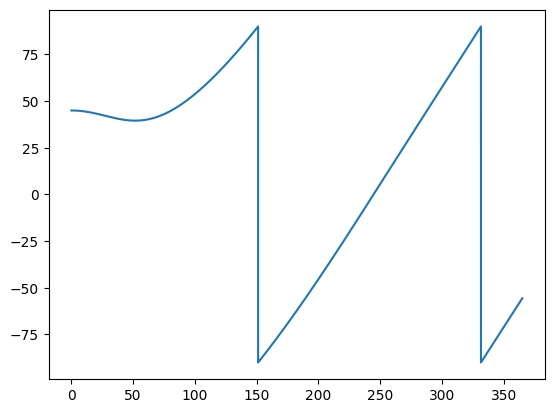

In [35]:
plt.plot(show_res[:, 0], show_res[:, 11])
plt.show()

In [ ]:
res

In [154]:
step = 0.05
t = np.arange(0, 5., step)
res = np.zeros(shape=(t.size, 3))
res[:, 0] = t
res[0][1:] = [2., 0]

for i in np.arange(1, res[:,0].size, 1):
    res[i][1:] = rk4.rk4_step(temp_eq, res[i-1][1:], res[i-1][0], step)

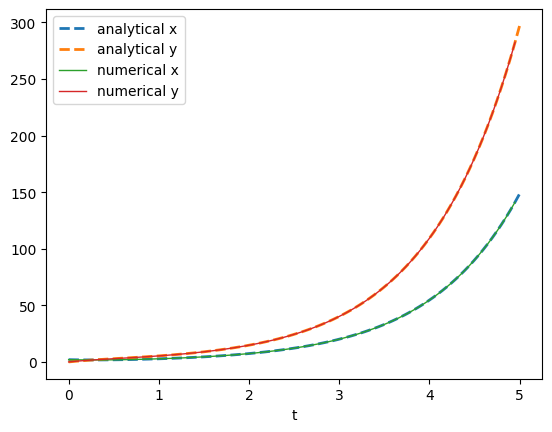

In [101]:
v = np.arange(0, 24, 1).reshape(6,4)
v[0, 1]

1